In [1]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip  -O /tmp/cats_and_dogs_filtered.zip

--2019-04-15 22:31:26--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  30.4MB/s    in 2.2s    

2019-04-15 22:31:29 (30.4 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:

import os
import zipfile

from keras.applications.vgg19 import VGG19

from keras import layers
from keras import models
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.models import load_model

import pickle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:


local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

conv_base.trainable = False

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 7s 0us/step


In [6]:
model = models.Sequential()
# Start from VGG19
model.add(conv_base)
# Add my custom classifier
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________
None


In [0]:
def lr_scheduler(epoch):
  lr = 1e-4
  if epoch >= 50:
      lr = 5e-6
  elif epoch >= 40:
      lr = 2e-5
  elif epoch >= 30:
      lr = 4e-5
  elif epoch >= 20:
      lr = 6e-5
  elif epoch >= 10:
      lr = 8e-5
  print('Learning rate: ', lr)
  return lr

In [8]:
# data augmentation of train set
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# only rescale for validation set
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model 
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(), 
    metrics=['acc'])

#model check point
mc = ModelCheckpoint('best_model_p1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# train
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[LearningRateScheduler(lr_scheduler),mc]
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
Learning rate:  0.0001
100/100 [==============================] - 23s 227ms/step - loss: 0.5979 - acc: 0.6760 - val_loss: 0.3731 - val_acc: 0.8300

Epoch 00001: val_acc improved from -inf to 0.83000, saving model to best_model_p1.h5
Epoch 2/50
Learning rate:  0.0001
100/100 [==============================] - 17s 174ms/step - loss: 0.4996 - acc: 0.7565 - val_loss: 0.3476 - val_acc: 0.8510

Epoch 00002: val_acc improved from 0.83000 to 0.85100, saving model to best_model_p1.h5
Epoch 3/50
Learning rate:  0.0001
100/100 [==============================] - 17s 173ms/step - loss: 0.4505 - acc: 0.7775 - val_loss: 0.3042 - val_acc: 0.8700

Epoch 00003: val_acc improved from 0.85100 to 0.87000, saving model to best_model_p1.h5
Epoch 4/50
Learning rate:  0.0001
100/100 [==============================] - 19s 189ms/step - loss: 0.4348 - acc: 0.8010 - val_los

In [0]:
model.save('checkpoint_hw3_p1_final.h5')
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
h = (acc, val_acc, loss, val_loss)
# Save History
pickle.dump( h, open( "p1.hist", "wb" ) )

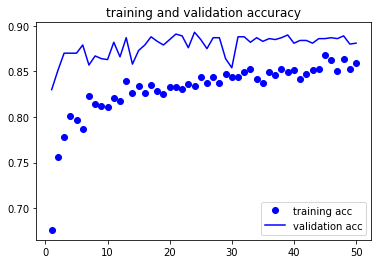

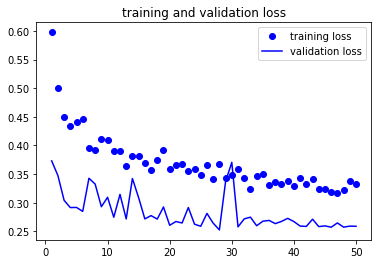

In [10]:

%matplotlib inline

(acc, val_acc, loss, val_loss) = pickle.load( open( "p1.hist", "rb" ) )
 
epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [11]:

from keras.models import load_model

# Deletes the existing model
del model  

# Load Model
model = load_model('best_model_p1.h5')
print(conv_base.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [12]:
conv_base.trainable = True
for layer in conv_base.layers:
  if layer.name == 'block5_conv4' or layer.name == 'block_conv3':
    layer.trainable = True
  else:
    layer.trainable = False
    
# compile model 
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(), 
    metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 22,122,049
Non-trainable params: 0
_________________________________________________________________


In [13]:
#model check point
mc2 = ModelCheckpoint('best_model_p2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# train using the same scheduler but it start with a lower learning rate
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    initial_epoch= 50,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[LearningRateScheduler(lr_scheduler),mc2]
)

Epoch 51/100
Learning rate:  5e-06
100/100 [==============================] - 30s 304ms/step - loss: 0.3242 - acc: 0.8565 - val_loss: 0.1560 - val_acc: 0.9430

Epoch 00051: val_acc improved from -inf to 0.94300, saving model to best_model_p2.h5
Epoch 52/100
Learning rate:  5e-06
100/100 [==============================] - 26s 258ms/step - loss: 0.2412 - acc: 0.9030 - val_loss: 0.1480 - val_acc: 0.9500

Epoch 00052: val_acc improved from 0.94300 to 0.95000, saving model to best_model_p2.h5
Epoch 53/100
Learning rate:  5e-06
100/100 [==============================] - 26s 257ms/step - loss: 0.2039 - acc: 0.9145 - val_loss: 0.1718 - val_acc: 0.9450

Epoch 00053: val_acc did not improve from 0.95000
Epoch 54/100
Learning rate:  5e-06
 99/100 [============================>.] - ETA: 0s - loss: 0.1686 - acc: 0.9313
Epoch 00054: val_acc improved from 0.95000 to 0.95600, saving model to best_model_p2.h5
Epoch 55/100
Learning rate:  5e-06
100/100 [==============================] - 26s 258ms/step -

In [0]:
model.save('checkpoint_hw3_p2_final.h5')
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
h = (acc, val_acc, loss, val_loss)
# Save History
pickle.dump( h, open( "p2.hist", "wb" ) )

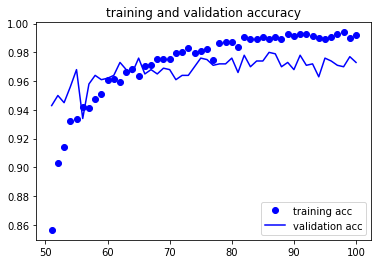

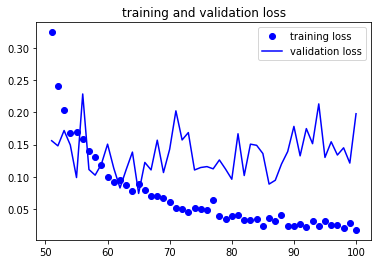

In [16]:
%matplotlib inline

(acc, val_acc, loss, val_loss) = pickle.load( open( "p2.hist", "rb" ) )

epochs = range(51, len(acc) + 51)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [17]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Val_acc:", val_acc,"Val_loss:", val_loss)
model.save('p2_final.h5')

Val_acc: 0.9729999959468841 Val_loss: 0.12663177601631218
